In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from models import *

In [2]:
AAPL = pd.read_csv("hist_data/AAPL.csv")
MSFT = pd.read_csv("hist_data/MSFT.csv")

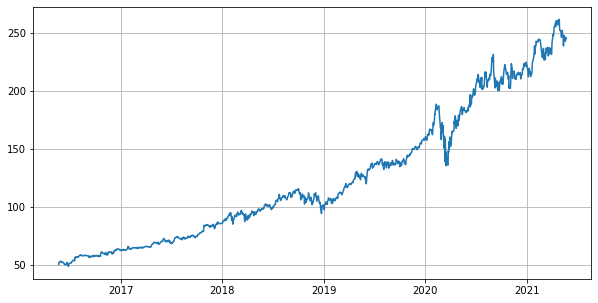

In [17]:
RS = RandomSampling(MSFT)
RS.plot()

In [18]:
q = 0.01
start = 0
begin = 365
end = None
evaluation_step = 14
simulation_steps = 30
simulations = 1000
print("VaR violation rate: ", RS.evaluate(start, begin, end, evaluation_step, q, simulation_steps, simulations))

VaR violation rate:  0.016129032258064516


2021-03-25 2021-05-10 30


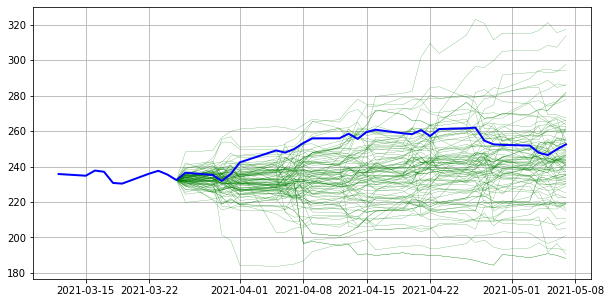

In [19]:
RS.plot_last_simulation(100, real_price=True)